## Notebook Purpose

Analyze feature map regularization results for ismrm paper. Previously tuned parameters, i.e. see `20201121_results_fm_regularizn_quant_across_trials.ipynb`

### Note
- Currently, fm_reg is run in the new pytorch environment, but fastmri results for ismrm were made in the old pytorch environment. hence need to port fm_reg over into old environment

In [196]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import json
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5
from utils.evaluate import calc_metrics, norm_imgs
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            crop_center

In [50]:
display_rows = 10#len(df)
pd.set_option('display.max_rows', display_rows)

def agg_sort_df(df_in):
    ''' given df, aggregate trial_ids across means for different file_ids
        sort df rows by the highest ssim_dc '''
    try:
        agg_fns = {'ssim_dc': 'mean', 'psnr_dc': 'mean', 'ssim_est':'mean', 'psnr_est':'mean', \
           'alpha_fm': 'first', 'num_iter': 'first', 'iter_start_fm_loss': 'first', \
           'weight_method': 'first', 'downsamp_method':'first'}
        df = df_in.groupby(df_in['trial_id']).aggregate(agg_fns).reset_index()
    except:
        agg_fns = {'ssim_dc': 'mean', 'psnr_dc': 'mean', 'ssim_est':'mean', 'psnr_est':'mean', \
           'alpha_fm': 'first', 'num_iter': 'first', \
           'weight_method': 'first', 'downsamp_method':'first'}
        df = df_in.groupby(df_in['trial_id']).aggregate(agg_fns).reset_index()
    df = df.sort_values(by='ssim_dc', ascending=False)
    
    return df

def load_gt(file_id):
    _, ksp_orig = load_h5(file_id)
    ksp_orig = torch.from_numpy(ksp_orig)
    return crop_center(root_sum_squares(ifft_2d(ksp_orig)), 320, 320)

def plot_list(arr_list, clim=(0, .1)):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', 'dd+']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

def compute_scores(path, trial_id=None):
    NUM_METRICS = 4
    NUM_SAMPS = len(file_id_list)
    NUM_VARS = 2 # gt, dc
    metric_list = np.empty((NUM_SAMPS, NUM_METRICS))
    im_list = np.empty((NUM_SAMPS, NUM_VARS, 320, 320))
    
    for idx, file_id in enumerate(file_id_list):
        
        if trial_id:
            fn_base = '{}{}_{}'.format(path, trial_id, file_id)
        else:
            fn_base = '{}{}'.format(path, file_id)
        
        img_gt = np.array(load_gt(file_id)).astype('float32')
        img_dc = np.load('{}_dc.npy'.format(fn_base)).astype('float32')
        
        img_gt, img_dc = norm_imgs(img_gt, img_dc)
        
        metric_list[idx] = calc_metrics(img_gt, img_dc)
        im_list[idx] = [img_gt, img_dc]
        
    return metric_list, im_list

In [221]:
path_fm = '/bmrNAS/people/dvv/out_fastmri/expmt_fm_loss/'
path_fm_8 = '/bmrNAS/people/dvv/out_fastmri/expmt_fm_loss/accel_8x/'
path_tb = path_fm + 'trials_best/'
path_6 = '/bmrNAS/people/dvv/out_fastmri/ismrm/model6/'

# n = 5 or n = 11 prototyping test set
file_id_list = ['1000273', '1000325', '1000464', \
                '1000537', '1000818', '1001140', '1001219', \
                '1001338', '1001598', '1001533', '1001798']
# file_id_list = file_id_list + ['1000000', '1000007', '1000017', '1000026', '1000031',
#                                  '1000033', '1000041', '1000052', '1000071', '1000073',
#                                  '1000107', '1000108', '1000114', '1000126', '1000153',
#                                  '1000178', '1000182', '1000190', '1000196', '1000201', 
#                                 '1000206', '1000229', '1000243', '1000247', '1000254',
#                                  '1000263', '1000264', '1000267']
# file_id_list = ['1000273', '1000325', '1000464', '1000537', '1000818']

### which dd+ model to compare

trial description
- environment: pt==1.7 is new, pt==1.5 is old
- returns: loss_ksp (old bug?) or loss_total
- thus (environment, returns)

trials
- 0000_10k: (new, ---) w alpha_fm=0
- autybby9: (new, loss_ksp) w alpha_fm non-zero
- dkrrw7xv: (new, loss_total)
- path_6: (old, ---) w alpha_fm=0
- tried accel_8x, and it was dogshit

### get quant results

In [222]:
metric_list_bl, im_list_bl = compute_scores(path_tb, '0000_10k')
metric_list_fm, im_list_fm = compute_scores(path_tb, 'autybby9')

print(np.mean(metric_list_bl, axis=0))
print(np.mean(metric_list_fm, axis=0))

In [223]:
IDX_OI = 1
metric_list_bl[IDX_OI], metric_list_fm[IDX_OI]

(array([ 0.52831795,  0.95148265,  0.69952687, 32.78089354]),
 array([ 0.57813941,  0.9526431 ,  0.76968058, 33.1828599 ]))

w n=11

[ 0.62201909  0.94783812  0.75140817 31.86894458]
[ 0.63941339  0.94933482  0.7619884  32.04480433]

w n=39

[ 0.64683873  0.94417609  0.74882881 31.6465128 ]
[ 0.64759432  0.94441593  0.75076202 31.6559696 ]

In [79]:
win_board = np.empty((metric_list_fm.shape), dtype='uint8')
delta_board = np.empty((metric_list_fm.shape))
NUM_SAMPS = len(metric_list_fm)

for idx in range(NUM_SAMPS):
    
    scores_bl = metric_list_bl[idx]
    scores_fm = metric_list_fm[idx]
    scores_delta = scores_fm - scores_bl
    
    win_board[idx] = [1 if s>=0 else 0 for s in scores_delta]
    
    delta_board[idx] = np.abs(scores_delta)

# win percentage on each metric
win_perc = np.sum(win_board, axis=0) / NUM_SAMPS 

# absolute difference: mean and std
delta_mu = np.mean(delta_board, axis=0)
delta_std = np.std(delta_board, axis=0)

print(win_perc)
print('')
print(delta_mu)
print(delta_std)

w n=11

[0.81818182 0.72727273 0.72727273 0.81818182]

[0.02318087 0.00300031 0.01294956 0.23042601]
[0.01423445 0.0015726  0.01886346 0.14056513]

w n=39

[0.56410256 0.56410256 0.51282051 0.53846154]

[0.02013492 0.00321181 0.00897205 0.22053075]
[0.01647661 0.00198981 0.01166183 0.1796695 ]

# TODO: sign up for ismrm trainee membership

In [227]:
IDX_OI = 1
FILE_ID_OI = file_id_list[IDX_OI]
print(FILE_ID_OI)

1000325


In [312]:
def plot_list(arr_list, clim=(0,.1), bbox=None, display_scores=True, inset=True):
    ''' given list of arrays arr_list, plot '''
    
    NUM_COLS = len(arr_list)
    title_list = ['GT', 'lam=0', 'lam=.001']
    im_gt = arr_list[0]
    
    fig = plt.figure(figsize=(20,20))
    plt.tight_layout()
    
    gs = gridspec.GridSpec(1,3)
    gs.update(wspace=0, hspace=0)
    
    for idx in range(NUM_COLS):
        ax = plt.subplot(gs[idx])
        
        im = arr_list[idx]
        
        if bbox:
            y0, x0, size = dict_inset_bbox[FILE_ID_OI]['bbox']
            rect = patches.Rectangle((y0,x0),size,size,linewidth=2,edgecolor='g',facecolor='none')
            ax.add_patch(rect)

        if display_scores:
            if idx == 0:
                textstr_1, textstr_2 = 'VIF', 'SSIM'
            elif idx == 1:
                textstr_1, textstr_2 = '0.53', '0.70'
            elif idx == 2:
                textstr_1, textstr_2 = '0.56', '0.76'
            ax.text(0.86, 0.11, textstr_1, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='cyan')
            ax.text(0.86, 0.055, textstr_2, transform=ax.transAxes, fontsize=21,
                    verticalalignment='top', color='yellow')
            
        ax.imshow(im, cmap='gray', clim=clim, aspect=1)
        
                    
        if inset:            
            axins = zoomed_inset_axes(ax, zoom=2, loc=1)
            EXTENT = 256 
            axins.imshow(im, cmap='gray', clim=clim, extent=[0,EXTENT,0,EXTENT])
            
            # origin for inset is lower left
            x0, y0, size = dict_inset_bbox[FILE_ID_OI]['inset']
            
            axins.set_anchor('NE')#, axins.axis('off')
            axins.set_xlim(x0, x0+size) # axes origin at upper left
            axins.set_ylim(y0, y0+size)
            plt.xticks(visible=False), plt.yticks(visible=False)
            plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False)
            plt.rcParams["axes.edgecolor"] = 'green'
            plt.rcParams["axes.linewidth"]  = 3
        
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

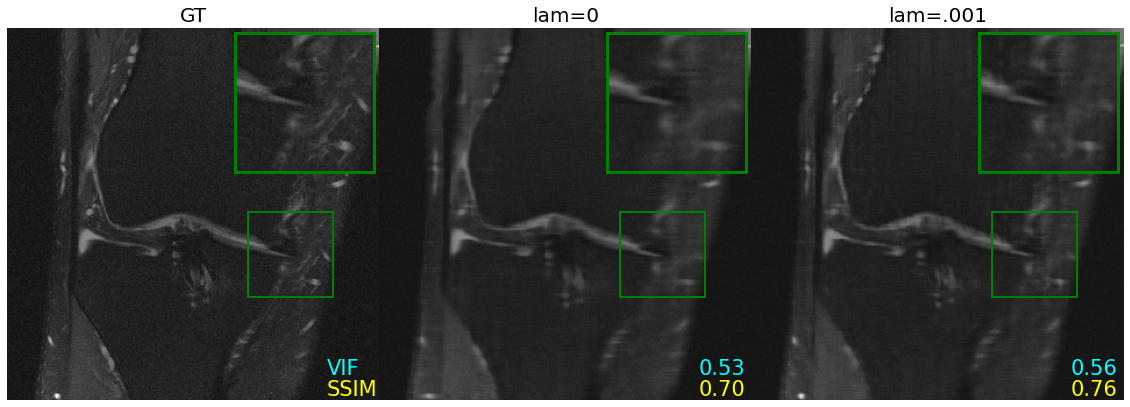

In [313]:
# dict_inset_bbox = {'1000325': {'bbox': (108, 158, 73),
#                                'inset': (85, 70, 60)}}
dict_inset_bbox = {'1000325': {'bbox': (207, 158, 73),
                               'inset': (165, 70, 60)}}

IDX_OI = 1
im_list_oi = [np.flip(im_list_fm[IDX_OI][0], 0), 
              np.flip(im_list_bl[IDX_OI][1], 0), 
              np.flip(im_list_fm[IDX_OI][1], 0)]

# temp = np.flip(np.array([im_list_oi[0]]), 0)
# plot_list(temp, bbox=True)

plot_list(im_list_oi, bbox=True)

In [149]:
# for idx in range(len(im_list_bl)):
#     plot_list(im_list_bl[idx])
#     plot_list(im_list_fm[idx])